# Initalize libraries

## Import libraries

In [1]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
import xarray as xr
import h5py
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Misc
from scipy.ndimage import gaussian_filter1d

# Open nexus files
from nexusformat.nexus import *

# Self-written libraries
sys.path.append(join(os.getcwd(),"library"))
import support_functions as sup
from interactive import cimshow

# Gifs
import imageio

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

In [2]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [3]:
# interactive plotting
import ipywidgets
%matplotlib widget

# Auto formatting of cells
#%load_ext jupyter_black

## Experiment specific Functions

In [4]:
PROPOSAL = 11018955
USER = getuser()

In [5]:
BASEFOLDER = "/asap3/petra3/gpfs/p04/2024/data/%s/" % PROPOSAL
sample_name = "2403_tomo"


# Load any kind of data from collection
def load_pre_scan_snapshot(scan_id, key):
    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (sample_name,scan_id))
    entry = "entry%d"%scan_id
    
    with h5py.File(fname, "r") as f:
        data = np.array(f[entry]["measurement"]["pre_scan_snapshot"][key][()])
        print("Loaded: %s" % (fname))
    return np.squeeze(data)

# Load any kind of data from measurements
def load_data(scan_id, key):
    fname = join(BASEFOLDER, "raw", "%s_%05d.h5" % (sample_name,scan_id))
    entry = "entry%d"%scan_id

    with h5py.File(fname, "r") as f:
        data = np.array(f[entry]["measurement"][key][()])
        print("Loaded key %s of %s" % (key, entry))
    return np.squeeze(data)

In [6]:
# Not implemented yet
def norm_hyst_data(ydata, norm):
    """
    Normalize hysteresis yaxis to +/- 1
    """
    ynorm = []
    for i in range(len(ydata)):
        tmp = ydata[i] / norm[i]
        tmp = tmp - np.mean(tmp[-5:])
        tmp = tmp / np.mean(tmp[:5])
        tmp = 2 * (tmp - 0.5)
        ynorm.append(tmp)

    return ynorm

In [7]:
from scipy.optimize import curve_fit
def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + c

In [6]:
BASEFOLDER

'/asap3/petra3/gpfs/p04/2024/data/11018955/'

# Experimental Details

In [8]:
# Dict with basic experimental parameter
experimental_setup = {}

# General saving folder
folder_general = sup.create_folder(join(BASEFOLDER, "processed"))
print("Output Folder: %s" % folder_general)


Output Folder: /asap3/petra3/gpfs/p04/2024/data/11018955/processed


# Single or combination of multiple diode scans

In [12]:
# Add scan numbers to combine in single plot
scan_ids = np.arange(1800,1828)#[1395,1382,1333]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "sz"#"mx" # "energy", "sx", "sy"
data_key_x2 = "sy"
data_key_y = "maxibeckhoff1adc1_rmean"#"mx"#"sz"#

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "maxibeckhoff1adc2_rmean"  # "petra_curr"

# Load data
xdata, ydata, norm = [], [], []
for scan_id in tqdm(scan_ids):
    try:
        data = load_data(scan_id, data_key_x)
    except:
        data = load_data(scan_id, "sy")
    xdata.append(data)
    ydata.append(load_data(scan_id, data_key_y))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(ydata[-1].shape))

  0%|          | 0/28 [00:00<?, ?it/s]

Loaded key sz of entry1800
Loaded key maxibeckhoff1adc1_rmean of entry1800
Loaded key sz of entry1801
Loaded key maxibeckhoff1adc1_rmean of entry1801
Loaded key sz of entry1802
Loaded key maxibeckhoff1adc1_rmean of entry1802
Loaded key sz of entry1803
Loaded key maxibeckhoff1adc1_rmean of entry1803
Loaded key sz of entry1804
Loaded key maxibeckhoff1adc1_rmean of entry1804
Loaded key sz of entry1805
Loaded key maxibeckhoff1adc1_rmean of entry1805
Loaded key sz of entry1806
Loaded key maxibeckhoff1adc1_rmean of entry1806
Loaded key sy of entry1807
Loaded key maxibeckhoff1adc1_rmean of entry1807
Loaded key sy of entry1808
Loaded key maxibeckhoff1adc1_rmean of entry1808
Loaded key sy of entry1809
Loaded key maxibeckhoff1adc1_rmean of entry1809
Loaded key sy of entry1810
Loaded key maxibeckhoff1adc1_rmean of entry1810
Loaded key sz of entry1811
Loaded key maxibeckhoff1adc1_rmean of entry1811
Loaded key sz of entry1812
Loaded key maxibeckhoff1adc1_rmean of entry1812
Loaded key sz of entry181

Saving: /asap3/petra3/gpfs/p04/2024/data/11018955/processed/ScanId_1800-1827_Diode_cklose.png


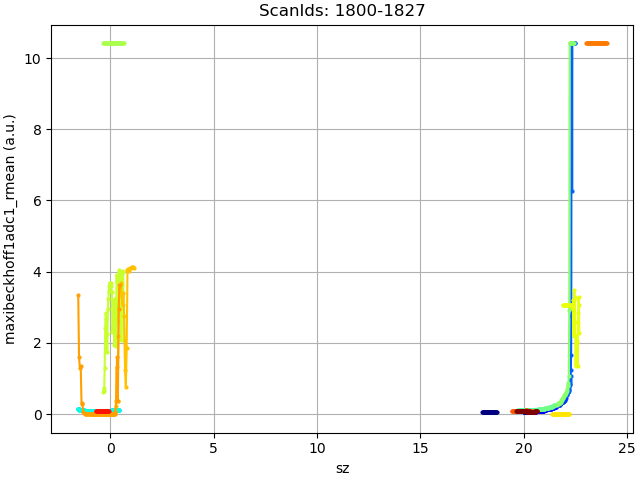

In [14]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Diode_%s.png" % (scan_ids[0], USER))

colors = plt.cm.jet(np.linspace(0,1,len(xdata)))

# Plot all scans together
fig, ax = plt.subplots()

# Iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d" % scan_ids[i],
        color = colors[i]
    )

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
#ax.legend()

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

## Fitting of scans with a gaussian

In [ ]:
# Add scan numbers to combine in single plot
scan_ids = [1100]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "sy"
data_key_y = "maxibeckhoff1adc1_rmean"

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "adc_beck_femto_goldmesh_mean"  # "petra_curr"


# Load energy/wavelength and add to experimental setup
try:
    experimental_setup["energy"] = np.array(load_energy(scan_ids[0]))
    experimental_setup["lambda"] = cci.photon_energy_wavelength(
        experimental_setup["energy"], input_unit="eV"
    )
except:
    pass

# Load data
xdata, ydata, norm = [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id, data_key_x))
    ydata.append(load_data(scan_id, data_key_y))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(ydata[-1].shape))

In [ ]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Fit_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Fit_%s.png" % (scan_ids[0], USER))


# Plot all scans together
fig, ax = plt.subplots()

fit = True

# Iterate over scans
for i, scan_id in enumerate(scan_ids):
    # Plot diode
    y = ydata[i] / norm[i]
    p = ax.plot(
        xdata[i],
        y,
        "o",
        markersize=2,
        label="Id: %d" % scan_ids[i],
    )
    
    # Initial fitting Parameter
    if fit is True:
        A0 = np.max(ydata[i] / norm[i])
        x0 = xdata[i][np.argmax(ydata[i])]
        sigma0 = 0.01
        c0 = 0  # np.min(ydata[i])
        popt, pcov = curve_fit(
            gaussian, xdata[i], y, p0=(A0, x0, sigma0, c0)
        )
        # popt returns the best fit values for parameters of the given model (func)
        print("Scan %d: A=%02f, x=%02f, sigma=%02f, c=%02f"%(scan_id,popt[0],popt[1],popt[2],popt[3]))
        color = p[0].get_color()
        # plot fit
        x = np.linspace(xdata[i][0], xdata[i][-1], 100)
        ym = gaussian(x, popt[0], popt[1], popt[2], popt[3])
        ax.plot(
            x, ym, color=color, label="FWHM = %.3f" % (2 * np.sqrt(2 * np.log(2)) * popt[2])
        )

        # Add vline line
        ax.axvline(popt[1], 0, 10, color=color)

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend()

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname)

# Rotation scans

In [ ]:
# Add scan numbers to combine in single plot
scan_ids = [883,890,893,898,901,904,907,910,915,918,921,924,929,932,935]
#scan_ids = [882,889,894,896,900,903,906,909,914,917,920,923,928,931,934]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "sy" # "energy", "sx", "sy"
data_key_y = "maxibeckhoff1adc1_rmean"
rot_key = "srotz"


# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "maxibeckhoff1adc2_rmean"  # "petra_curr"


if rot_key == "srotz":
    angle0 = 67


# Load energy/wavelength and add to experimental setup
try:
    experimental_setup["energy"] = np.array(load_energy(scan_ids[0]))
    experimental_setup["lambda"] = cci.photon_energy_wavelength(
        experimental_setup["energy"], input_unit="eV"
    )
except:
    pass

# Load data
xdata, ydata, norm, rot = [], [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id, data_key_x))
    ydata.append(load_data(scan_id, data_key_y))
    rot.append(load_pre_scan_snapshot(scan_id, rot_key))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(ydata[-1].shape))

In [ ]:
# Format title and output file name
if len(scan_ids) > 1:
    title = "ScanIds: %04d-%04d" % (scan_ids[0], scan_ids[-1])
    fname = join(
        folder_general,
        "ScanId_%04d-%04d_Diode_rot_%s.png" % (scan_ids[0], scan_ids[-1], USER),
    )
else:
    title = "ScanId: %04d" % (scan_ids[0])
    fname = join(folder_general, "ScanId_%04d_Diode__rot%s.png" % (scan_ids[0], USER))

colors = plt.cm.jet(np.linspace(0,1,len(xdata)))

# Plot all scans together
fig, ax = plt.subplots()

# Iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d, %s: %.1f (%.1f deg)" % (scan_ids[i],rot_key,rot[i],rot[i]-angle0),
        color = colors[i]
    )

# Plotting options
ax.set_title(title)
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])
ax.grid()
ax.legend(fontsize = 7)

# Different label with and without normalization
if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm, fontsize=7)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")

# Save plot
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

In [ ]:
peaks_x = np.stack(xdata)
peaks_y = np.stack(ydata)

peak_pos = []
for i,argmax in enumerate(np.argmax(peaks_y,axis=1)):
    peak_pos.append(peaks_x[i,argmax])

# Fitting
m,b = np.polyfit(rot, peak_pos, 1)
x = np.linspace(25,125,180)

sy = m*x+b
    
fig, ax = plt.subplots()
ax.plot(rot,peak_pos,"o",
        markersize=7,)
        #label="Id: %d, %s: %.1f (%.1f deg)" % (scan_ids[i],rot_key,rot[i],rot[i]-angle0))
ax.plot(x,sy,label = "Fit: %s = %.2f * %s + %.2f"%(data_key_x,m,rot_key,b))
ax.set_ylabel(data_key_x)
ax.set_xlabel(rot_key)
ax.set_title("Alignment Peak Position")
ax.grid()
ax.legend()

fname = join(
    folder_general,
    "ScanId_%04d-%04d_Diode_rot_peak_%s.png" % (scan_ids[0], scan_ids[-1], USER),
)
print("Saving: %s"%fname)

plt.savefig(fname)

In [ ]:
input_angle = 42
sy = m*input_angle+b
sy

# Other

In [79]:
data = {}
data["pinhole_z"] = [77,76.4,75.4,75.4,75.4,75.4,76.4,76.4,74.5,74.5,74.5,73,73.3]
data["hxsy"] = [-1.7899,-1.7899,-1.8416,-0.8942,0.0412,-2.7531,-1.8394,-0.8712,-0.9145,0.0196,-1.8595,-1.8046,-1.8]
data["hxsz"] = [-0.784,-0.784,-0.6728,-0.6718,-0.6986,-0.6308,-0.6695,-0.6693,-0.6538,-0.6537,-0.6535,-0.6552,-1]
data["transmission"] = [0.4,540,617,1185,346,0.8,545,1337,816,326,701,0.2,0.2]

In [80]:
data_xr = xr.Dataset()
data_xr["pinhole_z"] = xr.DataArray(data["pinhole_z"],dims=["index"])
data_xr["hxsz"] = xr.DataArray(data["hxsz"],dims=["index"])
data_xr["hxsy"] = xr.DataArray(data["hxsy"],dims=["index"])
data_xr["hxsy"] = np.round(2*data_xr["hxsy"],1)/2
data_xr["transmission"] = xr.DataArray(data["transmission"],dims=["index"])
data_xr["z"] = data_xr["hxsz"]  + data_xr["hxsy"]
data_xr["z"] = np.round(2*data_xr["z"],1)/2

In [81]:
colors = np.array(data_xr["transmission"].values)  # Assign z values as colors
norm = plt.Normalize(colors.min(), colors.max())  # Normalize the colors
cmap = plt.cm.plasma  # Choose a colormap (you can change it to any colormap you prefer)

# Plot the points with colors based on z values
#sc = ax.scatter(x, y, z, c=colors, cmap=cmap, marker='o', s=100)

Text(0.5, 0, 'z')

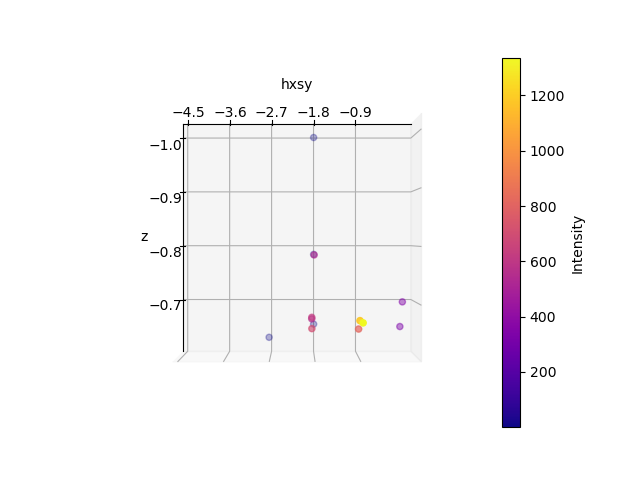

In [82]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(data_xr["hxsz"].values,data_xr["hxsy"].values ,data_xr["transmission"].values/data_xr["transmission"].max().values,c = colors,cmap=cmap)
ax.view_init(elev=90, azim=0)
ax.set_yticks(np.arange(-4.5,0,0.9))
ax.set_zticks([])
ax.zaxis.line.set_visible(False)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Intensity')
ax.set_ylabel("hxsy")
ax.set_xlabel("z")

In [ ]:
# Add scan numbers to combine in single plot
scan_ids = [1100]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "sy"
data_key_y = "maxibeckhoff1adc1_rmean"

# Normalization of diode signal with I0, e.g., with petra current or gold mesh (needs to be inserted during scan)
normalization = False
data_key_norm = "adc_beck_femto_goldmesh_mean"  # "petra_curr"


# Load energy/wavelength and add to experimental setup
try:
    experimental_setup["energy"] = np.array(load_energy(scan_ids[0]))
    experimental_setup["lambda"] = cci.photon_energy_wavelength(
        experimental_setup["energy"], input_unit="eV"
    )
except:
    pass

# Load data
xdata, ydata, norm = [], [], []
for scan_id in tqdm(scan_ids):
    xdata.append(load_data(scan_id, data_key_x))
    ydata.append(load_data(scan_id, data_key_y))

    if normalization is True:
        norm.append(load_data(scan_id, data_key_norm))
    else:
        norm.append(np.ones(ydata[-1].shape))

# Diode Trace Hysteresis

In [ ]:
def ramp_tan(npts: int, s: float, full=False):
    """Calculate truncated tangent ramp function.

    Parameters
    ==========
    npts: int
        Number of points to calculate
    s: float
        shape parameter (0<s≤1) varies curve from linear (s→0) to tan-shaped
    full: bool
        If True, return both arms of the loop by mirroring. This effectively
        doubles the number of points.

    Returns
    =======
    ramp: np.ndarray
        normalized ramp values
    """
    # if (s <= 0) or (s > 1):
    #     raise ValueError("shape parameter out of range 0<s≤1")
    x = s * np.linspace(-np.pi / 2, np.pi / 2, npts)
    y = np.tan(x) / np.tan(np.pi * s / 2)
    if full:
        y = np.append(y, y[::-1][1:])
    return y

In [ ]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [ ]:
# Choose scan id
scan_id = 2511

# Load trace data
fields = [
    f"adc_beck_femto_diodemax_trace",
    "adc_beck_femto_goldmesh_trace",
    "adc_beck_mtesla_trace",
]
adcs = [load_data(scan_id, f) for f in fields]

In [ ]:
# Create xarray dataset
ds = xr.Dataset()
ds["fields"] = ("index", adcs[2][:, 10:-10].flatten())  # magnetic field
ds["diode"] = ("index", adcs[0][:, 10:-10].flatten())  # diode current
ds["mesh"] = ("index", adcs[1][:, 10:-10].flatten())  # mesh current for normalization
ds["rising"] = (
    "index",
    gaussian_filter1d(np.gradient(ds["fields"]), 20) > 0,
)  # which hysteresis branch

In [ ]:
bins = np.max(ds.fields.values) * ramp_tan(100, 0.5, False)

ds_sel = ds
ds_sel["rising"] = ds_sel.rising.astype(bool)
up = ds_sel.where(ds_sel.rising).groupby_bins("fields", bins).mean()
down = ds_sel.where(~ds_sel.rising).groupby_bins("fields", bins).mean()

In [ ]:
fig, ax = plt.subplots()
ax.plot(1e2 * up.fields, 2 * normalize(up.diode / up.mesh) - 1, "o", ms=3)
ax.plot(1e2 * down.fields, 2 * normalize(down.diode / down.mesh) - 1, "o", ms=3)
ax.set_xlabel("field (mT)")
ax.set_ylabel("diode / mesh (arb. units)")
ax.set_title("scan %d: field sweep @ 0.2Hz" % (scan_id))
ax.grid()

fname = join(folder_general, "ScanId_%04d_Diode_Trace_%s.png" % (scan_id, USER))
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)